In [1]:
!pip install subword-nmt
!wget https://raw.githubusercontent.com/pacifikus/itmo_dl_nlp_course/refs/heads/main/Lecture%207/vocab.py
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2025-03-20 07:33:32--  https://raw.githubusercontent.com/pacifikus/itmo_dl_nlp_course/refs/heads/main/Lecture%207/vocab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2879 (2.8K) [text/plain]
Saving to: ‘vocab.py’

vocab.py            100%[===================>]   2.81K  --.-KB/s    in 0s      

2025-03-20 07:33:33 (33.6 MB/s) - ‘vocab.py’ saved [2879/2879]

--2025-03-20 07:33:33--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange
import os

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

cool_random_state = 59

import sys
sys.path.append('/kaggle/working/vocab.py')
#print(sys.path)

from vocab import Vocab
#dir(Vocab)

In [65]:
with open('/kaggle/working/data.txt') as f:
    print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



In [66]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

In [67]:
with open('/kaggle/working/train.en', 'w') as f_src, open('/kaggle/working/train.ru', 'w') as f_dst:
    for line in open('/kaggle/working/data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

Пока не придумал, что делать с предобработкой, кроме того, чтобы поменять num_symbols, минус балл

In [68]:
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('/kaggle/working/train.'+lang), open('/kaggle/working/bpe_rules.'+lang, 'w'), num_symbols=11000)
    bpe[lang] = BPE(open('/kaggle/working/bpe_rules.'+lang))

    with open('/kaggle/working/train.bpe.'+lang, 'w') as f_out:
        for line in open('/kaggle/working/train.'+lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 11000/11000 [00:13<00:00, 838.83it/s] 


In [69]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=cool_random_state,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: отель villa cap@@ ung находится в 30 минутах езды от международного аэропорта нгу@@ ра рай . до у@@ лу@@ ват@@ у и пад@@ анг - пад@@ анг вы доедете на автомобиле всего за 5 минут .
out: the villa cap@@ ung is a 30 - minute drive from ngurah rai international airport , while ulu@@ wat@@ u and padang padang are a 5 - minute drive away .

inp: гостям предоставляется бесплатная парковка на территории дома для отпуска .
out: the property offers free parking on the plot .

inp: отель se@@ tra@@ sar@@ i с уютными номерами и бесплатным wi - fi на всей территории расположен всего в 10 минутах езды от платной дороги па@@ стер в бан@@ дун@@ ге .
out: located just a 10 - minute drive from past@@ eur tol@@ l road in bandung , set@@ ras@@ ari hotel offers a cosy accommodation with free wifi access in all areas of the property .



In [70]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [71]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[    0,  3754,  4095,  1557,    29,     1,     1,     1],
        [    0,  4791,  2623,    29,     1,     1,     1,     1],
        [    0,  4069,  2569, 10850,    65,  5243,    29,     1],
        [    0,  6766,  2623,    29,     1,     1,     1,     1],
        [    0,  7585,  2064,    27,   796,    29,     1,     1]])

back to words
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'оборудован балкон .', 'подключен wi - fi .']


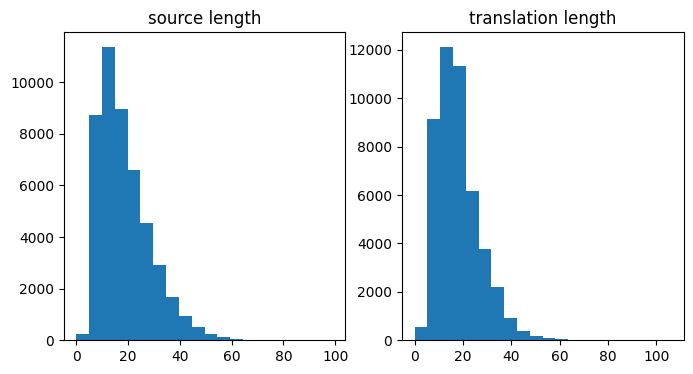

In [72]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [94]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size
        self.dec_size = dec_size
        self.hid_size = hid_size

        self.linear_enc = nn.Linear(enc_size, hid_size) 
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

In [145]:
class BasicModelPlus(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """
        A simple encoder-decoder seq2seq model with LSTM
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=True)
        #self.enc1 = nn.LSTM(hid_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size * 2, hid_size)
        self.dec0 = nn.GRUCell(hid_size * 2 + emb_size, hid_size)
        #self.dec1 = nn.LSTMCell(hid_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        self.attention = AttentionLayer(hid_size*2, hid_size, attn_size)

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference_greedy(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            next_token = logits.argmax(dim=-1)
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

            if (next_token == self.out_voc.eos_ix).all():
                break

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, strategy='greedy', **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        if strategy == 'greedy':
            out_ids, states = self.decode_inference_greedy(initial_state, **kwargs)
        elif strategy == 'topk':
            out_ids, states = self.decode_inference_topk(initial_state, **kwargs)
        elif strategy == 'temperature':
            out_ids, states = self.decode_inference_temperature(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

    def decode_inference_temperature(self, initial_state, max_len=100, temperature=0.2):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]

        all_states = [initial_state]
        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)
            
            next_token = torch.multinomial(probs, num_samples=1).squeeze(-1)   
            outputs.append(next_token)
            all_states.append(state)
    
            if (next_token == self.out_voc.eos_ix).all():
                break
    
        return torch.stack(outputs, dim=1), all_states

    def decode_inference_topk(self, initial_state, max_len=100, k=3):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]

        all_states = [initial_state]
        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            
            top_k_logits, top_k_indices = torch.topk(logits, k, dim=-1)
            probs = F.softmax(top_k_logits, dim=-1)
            
            next_token = torch.multinomial(probs, num_samples=1)
            next_token = top_k_indices.gather(dim=-1, index=next_token).squeeze(-1)
            outputs.append(next_token)
            all_states.append(state)
    
            if (next_token == self.out_voc.eos_ix).all():
                break
    
        return torch.stack(outputs, dim=1), all_states

In [120]:
model = BasicModelPlus(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [100]:
train_inp[:3]

array(['отель villa cap@@ ung находится в 30 минутах езды от международного аэропорта нгу@@ ра рай . до у@@ лу@@ ват@@ у и пад@@ анг - пад@@ анг вы доедете на автомобиле всего за 5 минут .',
       'гостям предоставляется бесплатная парковка на территории дома для отпуска .',
       'отель se@@ tra@@ sar@@ i с уютными номерами и бесплатным wi - fi на всей территории расположен всего в 10 минутах езды от платной дороги па@@ стер в бан@@ дун@@ ге .'],
      dtype='<U521')

In [101]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [102]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.8423, device='cuda:0', grad_fn=<NegBackward0>)


In [121]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', strategy='greedy', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, strategy, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [104]:
compute_bleu(model, dev_inp, dev_out)

0.0018168485531685516

Добавлена ранняя остановка и более продвинутый оптимизатор AdamW

In [105]:
metrics = {'train_loss': [], 'dev_bleu': [] }

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model.load_state_dict(torch.load('/kaggle/working/model_best.pth', weights_only=True))
model.to(device)

lr = 1e-3
wd = 1e-4

best_dev_bleu = -1
val_step = 50
p_ = 100
patience = p_

steps = 35000

model = BasicModelPlus(inp_voc, out_voc).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd) 
batch_size = 64

1) В качестве первого эксперимента заменил GRU и GRUCell слои на LSTM и LSTMCell слои соответственно, добавил также по одному дополнительному слою для энкодера и декодера. В итоге по графику видно обучения видно, что модель сходится заметно медленнее простой модели из лекции (по трейн лоссу), поэтому ждать конца обучения не стал
2) Убрал второй слой LSTM, но задал параметр bidirectional=True для энкодера. Стало чуть лучше по сравнению с первым экспериментом, но dev bleu вышел на плато на значении 14, на 15000-м шаге ('early stopping on step 23499 with best dev bleu 13.413')
3) Вернул GRU и GRUCell, bidirectional=True, модель сошлась несколько лучше, версия чем версия из лекции (early stopping on step 23599 with best dev bleu 19.879 против 18.48 с лекции). Видимо LSTM для наших небольших предложений в датасете оказался излишен. Попробую теперь поменять предобработку данных, напр. увеличить параметр num_symbols в learn_bpe()
4) learn_bpe(num_symbols=11000), прироста это не дало: 'early stopping on step 16249 with best dev bleu 19.612'
5) К улучшенному бейзлайну теперь нужно добавить attention-механизм -> 'early stopping on step 18049 with best dev bleu 25.659' (vs 22.96 в лекции)

Можно сделать вывод, что усложнение самих слоев не даёт прироста на наших данных, и GRU хорошо справляется с задачей. Большой прирость дали параметр bidirectional и механиз внимания. Поэтому, чтобы подбить метрику ещё выше, можно было бы попробовать увеличить размер эмбеддингов и скрытого пространства, усовершенствовать attention, сделав его multi-head, а также добавить lr_scheduler, напр. ReduceLROnPlateau.

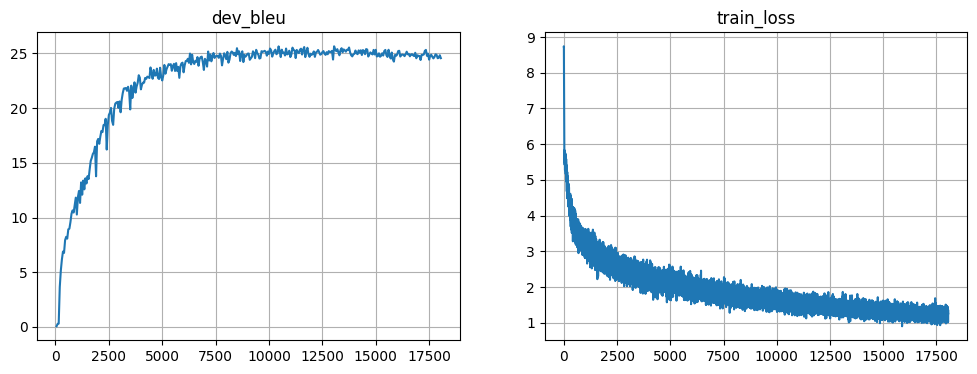

Mean loss=1.207


 52%|█████▏    | 18049/35000 [47:21<44:29,  6.35it/s]

early stopping on step 18049 with best dev bleu 25.659


In [106]:
for i_ in trange(steps):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % val_step == 0:
        dev_bleu = compute_bleu(model, dev_inp, dev_out)
        if dev_bleu > best_dev_bleu:
            best_dev_bleu = dev_bleu
            patience = p_
            torch.save(model.state_dict(), '/kaggle/working/model_best.pth')
        else:
            patience -= 1
        metrics['dev_bleu'].append((step, dev_bleu))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

    if patience <= 0:
        print(f'early stopping on step {i_} with best dev bleu {best_dev_bleu:.3f}')
        break
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [116]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "''"

In [146]:
model = BasicModelPlus(inp_voc, out_voc).to(device)
model.load_state_dict(torch.load('/kaggle/working/model_best.pth', weights_only=True))

<All keys matched successfully>

In [147]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

до стадиона бо@@ ру@@ сси@@ я парк можно добраться за 12 минут на машине .
the stadium national park is 12 minutes away by car .

в собственной ванной комнате установлена ванна .
there is a private bathroom with a bath .

гостям предоставляется постельное белье .
bed linen is available .

по запросу и за дополнительную плату для гостей организуют трансфер .
on request , the property can be arranged for an extra charge .

на круглосуточной стойке регистрации работает прокат автомобилей и велосипедов .
the hotel also offers car hire and car hire .

апартаменты ho@@ mer@@ e@@ z - avenue du do@@ c@@ te@@ ur ra@@ y@@ mond pi@@ ca@@ u@@ d расположены в каннах . к услугам гостей открытый бассейн .
offering an outdoor pool , cabañas so@@ gn@@ u de vi@@ a@@ da is located in the man@@ da mountains of buenos aires .



In [148]:
compute_bleu(model, dev_inp, dev_out)

25.659408197762236

Помимо жадного семплирования добавил top-k семлирование и семплирование с температурой (почему бы и нет)

In [149]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], strategy='temperature')[0]):
    print(inp_line)
    print(trans_line)
    print()

до стадиона бо@@ ру@@ сси@@ я парк можно добраться за 12 минут на машине .
the stadium of our lady is 12 minutes away by car .

в собственной ванной комнате установлена ванна .
there is a private bathroom with a bath .

гостям предоставляется постельное белье .
bed linen is available .

по запросу и за дополнительную плату для гостей организуют трансфер .
a shuttle service is available upon request and against a surcharge .

на круглосуточной стойке регистрации работает прокат автомобилей и велосипедов .
the hotel also offers car hire and car hire .

апартаменты ho@@ mer@@ e@@ z - avenue du do@@ c@@ te@@ ur ra@@ y@@ mond pi@@ ca@@ u@@ d расположены в каннах . к услугам гостей открытый бассейн .
offering an outdoor pool , maison d du parc du 4 is located in the puerto de europa mountains .



In [150]:
compute_bleu(model, dev_inp, dev_out, strategy='temperature')

25.065374266383188

In [151]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], strategy='topk')[0]):
    print(inp_line)
    print(trans_line)
    print()

до стадиона бо@@ ру@@ сси@@ я парк можно добраться за 12 минут на машине .
national stadium , 12 can be reached within 12 minutes .

в собственной ванной комнате установлена ванна .
there is a private bathroom with a bath .

гостям предоставляется постельное белье .
bed linen is provided .

по запросу и за дополнительную плату для гостей организуют трансфер .
a transfer to offer a tennis at an extra cost .

на круглосуточной стойке регистрации работает прокат автомобилей и велосипедов .
guests can rent a 24 - hour front desk and the area .

апартаменты ho@@ mer@@ e@@ z - avenue du do@@ c@@ te@@ ur ra@@ y@@ mond pi@@ ca@@ u@@ d расположены в каннах . к услугам гостей открытый бассейн .
offering an outdoor pool , cabañas re@@ da dv@@ z is a self - catering accommodation located in cannes .



In [152]:
compute_bleu(model, dev_inp, dev_out, strategy='topk')

21.329150139806423

Наверное более уместно было бы сделать сэмплирование, которое в теории улучшило бы качество перевода, напр. beam search, но да ладно..